**Quantile Regression DQN on Cartpole**

Distributional RL using Quantile Regression. 

**References:**

[1] https://arxiv.org/abs/1710.10044

[2] https://github.com/BY571/QR-DQN/blob/master/QR-DQN.ipynb


In [ ]:
!pip install gym box2d-py gym[box2d]
# !pip install gym[box2d] 

     |████████████████████████████████| 450kB 5.7MB/s 


Training...
Episode 3 : Average Reward 17.000 Epsil 0.726

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 99 : Average Reward 112.210 Epsil 0.010
Episode 199 : Average Reward 146.080 Epsil 0.010
Episode 299 : Average Reward 73.840 Epsil 0.010
Episode 399 : Average Reward 107.640 Epsil 0.010
Episode 499 : Average Reward 84.460 Epsil 0.010
Episode 549 : Average Reward 107.270 Epsil 0.010

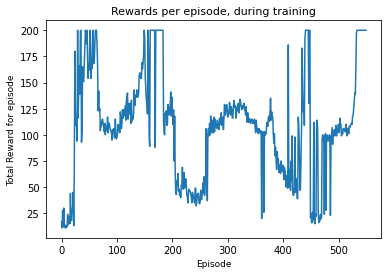

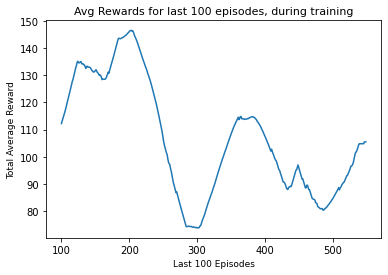


Testing...
Episode 99 : Average Reward 200.000
Episode 199 : Average Reward 200.000
Episode 299 : Average Reward 200.000


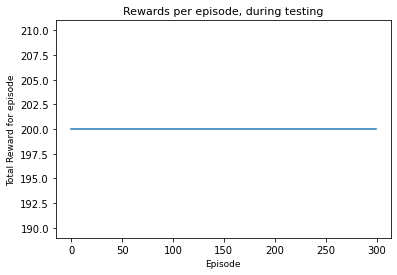

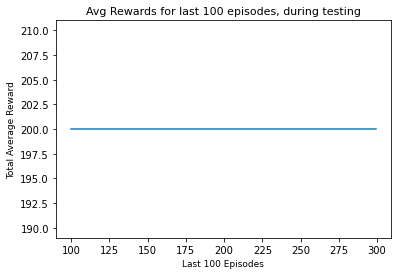

In [2]:
import random
from collections import deque

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

#from IPython import display
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


EPISODES = 550
TEST_EPISODES = 300
BATCH_SIZE = 32
UPDATE_MODEL = 1
UPDATE_TAU = 1e-2
AVG_REWARD_STOP_LEARNING = 190
SEED = 42

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, n_input, n_output, N, n_hidden=64):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(n_input, n_hidden, bias=True)
        self.layer2 = nn.Linear(n_hidden, n_hidden, bias=True)
        self.layer3 = nn.Linear(n_hidden, n_output*N, bias=True)
        self.n_output = n_output
        self.N = N

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        x = x.view(-1, self.N, self.n_output)
        return x

def get_e_greedy_action(rlnet, state, n_actions, epsilon):
    if np.random.random() < epsilon:
        return torch.tensor([[np.random.choice(range(n_actions))]], dtype=torch.long)
    
    with torch.no_grad():
        state = torch.FloatTensor(state).to(device=device)
        max_action = rlnet(state).mean(dim=1).argmax(dim=1)

    return max_action

def get_batch(buffer):
    if len(buffer) < BATCH_SIZE: return None
    
    smple = random.sample(buffer, BATCH_SIZE)
    
    # https://www.geeksforgeeks.org/python-get-first-element-of-each-sublist/
    states = torch.FloatTensor(list(zip(*smple))[0]).to(device=device)
    actions = torch.LongTensor(list(zip(*smple))[1]).view(-1, 1).to(device=device)
    next_states = torch.FloatTensor(list(zip(*smple))[2]).to(device=device)
    rewards = torch.FloatTensor(list(zip(*smple))[3]).view(-1, 1).to(device=device)
    terminal = torch.FloatTensor(list(zip(*smple))[4]).view(-1, 1).to(device=device)

    batch = (states, actions, next_states, rewards, terminal)
    return batch

def train_model(rlnet, tgtnet, optimizer, batch, gamma, N, beta=1.0):
    if not batch: return rlnet, tgtnet, optimizer

    n_input, n_output = env.observation_space.shape[0], env.action_space.n

    # train on random sample
    states, actions, next_states, rewards, terminal = batch

    pred_vals = rlnet(states)
    pred_vals = pred_vals.gather(2, actions.unsqueeze(-1).expand(-1, N, 1))
    # torch.Size([BATCH_SIZE, N, 1])

    true_vals = tgtnet(next_states).detach()
    action_indx = torch.argmax(true_vals.mean(dim=1), dim=1, keepdim=True)
    true_vals = true_vals.gather(2, action_indx.unsqueeze(-1).expand(-1, N, 1)).transpose(1,2)
    true_vals = rewards.unsqueeze(-1) + (gamma * true_vals * (1 - terminal.unsqueeze(-1)))
    # torch.Size([BATCH_SIZE, 1, N])

    # Compute Huber loss
    huber_loss = F.smooth_l1_loss(pred_vals, true_vals, reduction='none', beta=beta)
    # torch.Size([BATCH_SIZE, N, N])
    
    errors = true_vals - pred_vals
    tau = torch.FloatTensor([i/N for i in range(1, N+1)]).to(device=device)
    quantil_l = abs(tau -(errors.detach() < 0).float()) * huber_loss / 1.0

    loss = quantil_l.sum(dim=1).mean(dim=1)
    loss = loss.mean()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return rlnet, tgtnet, optimizer

def run_dqn(env, epsil, epsilon_min, epsilon_decay, gamma, alpha, buffer_len, N):
    
    n_input, n_output = env.observation_space.shape[0], env.action_space.n

    # Initialize replay memory D to capacity N
    replay = deque(maxlen=buffer_len)

    # Initialize action-value function Q with random weights
    rlnet = Net(n_input, n_output, N).to(device)
    optimizer = torch.optim.Adam(rlnet.parameters(), lr=alpha)

    # Initialize target action-value function ^Q with weights = Q 
    tgtnet = Net(n_input, n_output, N).to(device)
    tgtnet.load_state_dict(rlnet.state_dict())

    d = deque(maxlen=100)
    eps_reward = []
    frame = 0

    for ep in range(EPISODES):
        state = env.reset()
        
        action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

        done = False
        timesteps = 1
        total_reward = 0

        while True:
            timesteps += 1
            frame += 1
            
            action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

            # execute action in environment
            next_state, reward, done, info  = env.step(action)
            
            # add rewards for evaluation
            total_reward += reward

            # add to experience replay buffer
            replay.append([state, action, next_state, reward, done])

            # Sample random minibatch of transitions
            batch = get_batch(replay)

            # train on batch
            rlnet, tgtnet, optimizer = train_model(rlnet, tgtnet, optimizer,
                                                batch, gamma, N)
            
            # copy over model parameters to target network
            if timesteps % UPDATE_MODEL == 0:
                for target_param, local_param in zip(tgtnet.parameters(), rlnet.parameters()):
                    target_param.data.copy_(UPDATE_TAU*local_param.data + (1.0-UPDATE_TAU)*target_param.data)

            state = next_state
            
            if done:
                d.appendleft(total_reward)
                eps_reward.append(total_reward)
                break

            # decay epsilon
            epsil = max(epsilon_min, epsil * epsilon_decay)

        print('\rEpisode {} : Average Reward {:.3f} Epsil {:.3f}'.format(ep, np.mean(d), epsil), end="")
        if (ep + 1) % 100 == 0:
            print('\rEpisode {} : Average Reward {:.3f} Epsil {:.3f}'.format(ep, np.mean(d), epsil))

        if np.mean(d) > AVG_REWARD_STOP_LEARNING:
            break

    return rlnet, epsil, eps_reward

def test_dqn(env, rlnet, epsil):
    
    n_input, n_output = env.observation_space.shape[0], env.action_space.n

    d = deque(maxlen=100)

    eps_reward = []
    
    for ep in range(TEST_EPISODES):
        state = env.reset()
        
        action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

        done = False
        timesteps = 1
        total_reward = 0

        while True:
            timesteps += 1
            
            action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

            # execute action in environment
            next_state, reward, done, info  = env.step(action)
            
            # add rewards for evaluation
            total_reward += reward

            state = next_state
            
            if done:
                d.appendleft(total_reward)
                eps_reward.append(total_reward)
                break

        print('\rEpisode {} : Average Reward {:.3f}'.format(ep, np.mean(d)), end="")
        if (ep + 1) % 100 == 0:
            print('\rEpisode {} : Average Reward {:.3f}'.format(ep, np.mean(d)))
    
    return eps_reward

def plot_exp_reward_per_episode(rewards, train_test):
    #  Reward at each training episode while training your agent
    plt.plot(rewards)

    plt.title('Rewards per episode, during ' + train_test, fontsize=11)
    plt.xlabel('Episode', fontsize=9)
    plt.ylabel('Total Reward for episode', fontsize=9)
    plt.savefig("rewards_per_episode_" + train_test + ".png")

    plt.show()

def plot_exp_avg_reward_100_episode(rewards, train_test):
    avgd_rewards = []

    for i in range(100, len(rewards)):
        avgd_rewards.append(np.mean(rewards[i-100:i]))

    plt.plot(range(100, len(rewards)), avgd_rewards)

    plt.title('Avg Rewards for last 100 episodes, during ' + train_test, fontsize=11)
    plt.xlabel('Last 100 Episodes', fontsize=9)
    plt.ylabel('Total Average Reward', fontsize=9)
    plt.savefig("avg_rewards_per_100_episodes_" + train_test + ".png")

    plt.show()

def run_qr_dqn(env):
    buffer_len = 100000
    gamma = 0.99
    alpha = 1e-3
    epsil = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    N = 32

    print("Training...")
    rlnet, epsil, tr_rewards = run_dqn(env, epsil, epsilon_min, epsilon_decay,
                                       gamma, alpha, buffer_len, N)
    
    plot_exp_reward_per_episode(tr_rewards, "training")
    plot_exp_avg_reward_100_episode(tr_rewards, "training")
    
    print()
    
    print("Testing...")
    te_rewards = test_dqn(env, rlnet, 0)
    
    plot_exp_reward_per_episode(te_rewards, "testing")
    plot_exp_avg_reward_100_episode(te_rewards, "testing")
    
    return tr_rewards, te_rewards

env = gym.make('CartPole-v0')
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

tr_rewards, te_rewards = run_qr_dqn(env)